In [2]:
# This cell is used for creating a button that hides/unhides code cells to quickly look only the results.
# Works only with Jupyter Notebooks.

from __future__ import division

from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
# Description:
#   Exercise3 notebook.
#
# Copyright (C) 2018 Santiago Cortes, Juha Ylioinas
#
# This software is distributed under the GNU General Public 
# Licence (version 2 or later); please refer to the file 
# Licence.txt, included with the software, for details.

# Preparations
import os
from IPython import get_ipython
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from numpy.fft import fftshift, fft2
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, map_coordinates
from scipy.ndimage import convolve as conv2
from scipy.ndimage import convolve1d as conv1

from utils import *
from utils import rgb2gray, imnoise, add_gaussian_noise, gaussian2, affinefit, \
show_pyramid_horizontally, contains_forbidden_usage

# Select data directory

if os.path.isdir('/coursedata'):
    # JupyterHub
    course_data_dir = '/coursedata'
elif os.path.isdir('../../../coursedata'):
    # Local installation
    course_data_dir = '../../../coursedata'
else:
    # Docker
    course_data_dir = '/home/jovyan/work/coursedata/'

print('The data directory is %s' % course_data_dir)
data_dir = os.path.join(course_data_dir, 'exercise-03-data')
print('Data stored in %s' % data_dir)

The data directory is /coursedata
Data stored in /coursedata/exercise-03-data


# CS-E4850 Computer Vision Exercise Round 3

The exercises should be solved and the solutions submitted via Aalto JupyterHub by the deadline.

**Deliverables:**
- **Jupyter notebook** (.ipynb) containing your solutions to the programming tasks. Do not change the name of the notebook file. It may result in 0 points for the exercise.

**Important:**
- Fill only the cells marked with `# YOUR CODE HERE`. Do not change function signatures.
- You may add extra cells for your own tests, but **do not** overwrite global variables or edit locked cells.
- **Never create new cells by menu commands "Edit/Copy Cells" and "Edit/Paste Cells ..."**. These commands create cells with duplicate ids and make autograding impossible. Use menu commands "Insert/Insert Cell ..." or the button with a plus sign to insert new cells.
- **All notebooks contain hidden tests** which are used for grading. They are hidden inside read-only cells. Therefore, **the read-only cells should never be removed.** 
- **Note:** Visible tests mainly check the shapes and data types of your function’s output. Hidden tests check the correctness of your solution more thoroughly. Passing the visible tests does not guarantee full points for the exercise.
- **Google Colab warning:** Uploading your assignment notebooks to Colab may cause problems. Colab can overwrite notebook metadata and break the autograding. To avoid this, we recommend copy-pasting your code into the notebooks fetched on JupyterHub. Sorry for the inconvenience.
- Be sure that everything that you need to implement should work with the pictures specified by the assignments of this exercise round.
- Running the cells in mixed order (which quite often happens while trying different things and debugging) may cause errors. While working on a particular cell be sure that you have freshly run all its preceding cells belonging to the same exercise.
- **Before submitting**, simply run all the cells of the notebook (for example, select "Restart & Run All" in the menu) and check that all the cells run properly.
- **Remember to submit your assignment!**

Fill your name and student number below.

### Name:
### Student number:

## This exercise round doesn't have any pen&paper tasks.

## Exercise 1 - Image denoising (10 points)

In this exercise, you will denoise two noise-corrupted images using the following methods:

a) **Gaussian filtering using horizontal and vertical 1D convolutions** (see Section 3.2.1 of Szeliski’s book),

b) **Median filtering** (Section 3.3.1 of Szeliski’s book), and <br>

c) **Bilateral filtering** (Section 3.3.1 of Szeliski’s book).

### Load, corrupt, and visualize test images

In this step, you will load a grayscale test image, corrupt it with two types of noise, and display the results:

- `imns`: corrupted with **salt-and-pepper** noise
- `imng`: corrupted with **Gaussian** noise


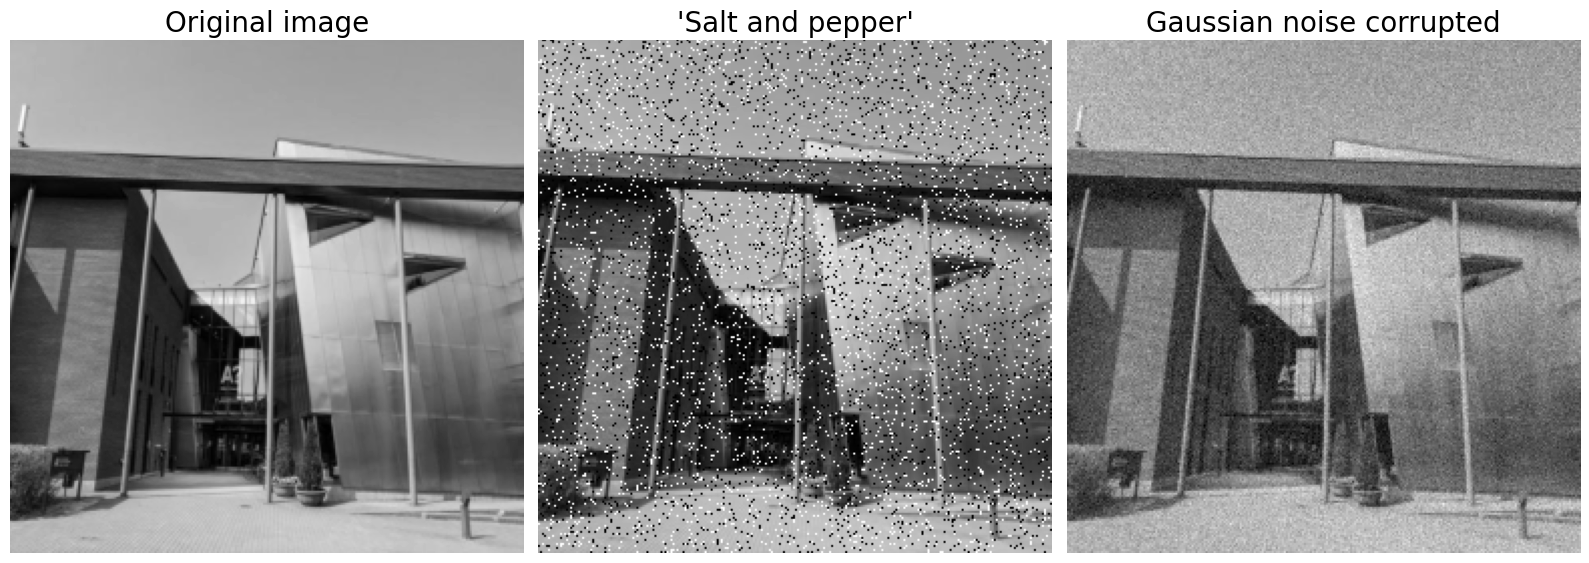

In [4]:
## Load test image
## Note: Must be double precision in the interval [0,1].
im = rgb2gray(imread(data_dir+'/department2.jpg')) / 255.
im = resize(im, (256, 256))

## Add noise
## "salt and pepper" noise
imns = imnoise(im, 'salt & pepper', 0.05)
## zero-mean gaussian noise
imng = im + 0.05*np.random.randn(im.shape[0],im.shape[1])

# Display original and noise corrupted images
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,8))
ax = axes.ravel()
ax[0].imshow(im, cmap='gray')
ax[0].axis('off')
ax[0].set_title("Original image", fontsize=20)
ax[1].imshow(imns, cmap='gray')
ax[1].axis('off')
ax[1].set_title("'Salt and pepper'", fontsize=20)
ax[2].imshow(imng, cmap='gray')
ax[2].axis('off')
ax[2].set_title("Gaussian noise corrupted", fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

### 1a) Gaussian filtering using horizontal and vertical 1D convolutions

In this part, you'll learn how to replace a 2D Gaussian convolution with two faster 1D convolutions by taking advantage of filter separability.  The task is divided into two steps:

- **1a) Step 1**: You will begin with a small 3×3 Gaussian kernel to understand how a 2D Gaussian filter can be separated into horizontal and vertical 1D filters.
- **1a) Step 2**: You will perform convolution with the 1D filters and verify that the results match the 2D convolution.

See Szeliski's book Chapter 3.2.1 Separable filtering, `numpy.linalg.svd` and `scipy.ndimage.convolve1d` for more details.


#### 1a) Step 1: Separate a 2D Gaussian filter into horizontal and vertical 1D filters
Szeliski's Book Chapter 3.2.1: "*A more direct method is to treat the 2D kernel
as a 2D matrix K and to take its singular value decomposition (SVD)*
$$\mathbf{K} = \sum_i \sigma_i \mathbf{u}_i \mathbf{v}_i$$
... $\sqrt{\sigma_0}\mathbf{u}_0$  and $\sqrt{\sigma_0}\mathbf{v}_0^\top$ *provide the vertical and horizontal kernels*"

##### **Task**
Implement the function `separate_filter`. Once complete, you can test it using the following 2D filter:
$$
\begin{bmatrix}
1 & 2 & 1\\
2 & 4 & 2\\
1 & 2 & 1
\end{bmatrix}
$$ 
Do not hard-code $\sigma$ or kernel size, the function must work with any separable 2D Gaussian filter.

In the `separate_filter` function.

- Start by computing the **Singular Value Decomposition (SVD)** of the 2D filter.
- Then compute the 1D **horizontal** (row vector) and **vertical** (column vector) filters as described above.
- The **output vectors** should have the following shapes:
  - `gv` should be a column vector of shape (h, 1)
  - `gh` should be a row vector of shape (1, w)
  
  where `h` and `w` are the height and width of the input 2D filter `g`.
  
##### **Note**
- The resulting 1D filters should be able to reconstruct the original 2D filter using matrix multiplication: `gv @ gh`.


In [5]:
# 2D filter, which will be separated to 1D filters
g = [[1, 2, 1], 
     [2, 4, 2], 
     [1, 2, 1]]

# Implement `separate_filter_svd` which separates the 2D filter `g` 
# into two 1D filters: `gv` (vertical) and `gh` (horizontal)
# See the instructions above for more details.
def separate_filter(g):

    g = np.array(g)
    h, w = g.shape
    
    ##-your-code-starts-here-##
    # YOUR CODE HERE
    raise NotImplementedError()
    ##-your-code-ends-here-##
    
    return gv, gh


In [6]:
# Visible tests

# Check shapes and reconstruction
g = [[1, 2, 1], 
     [2, 4, 2], 
     [1, 2, 1]]
gv, gh = separate_filter(g)

print("Your separated 1D filters")
print("gv:\n", gv)
print("gh:\n", gh, "\n")

reconstructed = gv @ gh
print("The reconstructed 2D filter:\n", reconstructed)

reconst_error = np.sum(np.abs(reconstructed - g)) 
print(f"Reconstruction error: {reconst_error} \n")

# Visible asserts
assert gv.shape == (3, 1), f'Error: The shape of gv is incorrect. gv should be a column vector of shape (3, 1), but got {gv.shape}.'
assert gh.shape == (1, 3), f'Error: The shape of gh is incorrect. gh should be a row vector of shape (1, 3), but got {gh.shape}.'
assert np.allclose(reconstructed, g, atol=1e-5), "The reconstructed 2D filter is not close enough to the original one."

print('All visible tests passed successfully!')

NotImplementedError: 

In [7]:
# HIDDEN TEST CELL
# This cell contains hidden test cases that will be evaluated after the deadline.
# Please do not remove or modify this cell, as it is required for grading.


#### 1a) Step 2: Filter using the horizontal and vertical 1D convolutions 

First, let's see how filtering is performed using 2D convolution with the `conv2` function. Note that we use a Gaussian filter, `g_large`, with a larger kernel size than in the previous step.

In [ ]:
# REFERENCE (read-only cell)
# 2D convolution with a large kernel size Gaussian

# Apply Gaussian filter of std 2.5 
sigmad = 2.5
g_large,_,_,_,_,_, = gaussian2(sigmad)

# Reference results with 2D convolution
gflt_imns_2D = conv2(imns, g_large, mode='reflect')
gflt_imng_2D = conv2(imng, g_large, mode='reflect')

##### **Task** 
Now, it's your turn to filter using the horizontal and vertical 1D convolutions. 
 
1. Use your previously implemented function, `separate_filter`, to separate the 2D filter `g_large` into horizontal and vertical 1D filters.

2. Apply the 1D filters using `conv1` (not `conv2`), performing the filtering operation twice, once in each direction. The result should match the output of the 2D convolution computed earlier.

3. Filter both images, `imns` and `imng`, and store the filtering results in the variables `gflt_imns` and `gflt_imng`, respectively.  

##### **Important** 
- **Do not use 2D convolution, e.g. `conv2`, in this task.** The goal is to demonstrate the separability of the filter using two consecutive 1D convolutions.
- The `separate_filter` function returns 2D vectors (a column and a row). To use them with `conv1`, you must flatten them to 1D using `.ravel()`, e.g. `gv.ravel()`
- You may choose the `mode` parameter freely when using `conv1` (e.g., `'reflect'`, `'nearest'`, etc.). The effect of the chosen mode is limited to the image borders and is accounted for in the tests.
- `conv1` is an alias for [`scipy.ndimage.convolve1d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve1d.html). 
Use the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve1d.html) to check available parameters and usage examples.


In [ ]:
# Use your previously implemented function to separate the 2D filter `g_large`
gv, gh = separate_filter(g_large)

# TASK:
# Filter using two 1D convolutions: horizontal and vertical.
# Filter both images `imns` and `imng, and store the filtering 
# results in `gflt_imns` and `gflt_imng`, respectively.  
# Use conv1 function, conv2 is not allowed here
##-your-code-starts-here-##
# YOUR CODE HERE
raise NotImplementedError()
##-your-code-ends-here-##

In [ ]:
# Visible tests

# Check result shape
assert gflt_imns.shape == imns.shape, "Output shape for gflt_imns is incorrect"
assert gflt_imng.shape == imng.shape, "Output shape for gflt_imng is incorrect"

# Compare only the central region (to ignore border differences due to padding mode)
margin = g_large.shape[0] // 2
gflt_imns_crop = gflt_imns[margin:-margin, margin:-margin]
gflt_imns_2D_crop = gflt_imns_2D[margin:-margin, margin:-margin]
gflt_imng_crop = gflt_imng[margin:-margin, margin:-margin]
gflt_imng_2D_crop = gflt_imng_2D[margin:-margin, margin:-margin]

# Compute and report reconstruction errors
reconst_error_ns = np.sum(np.abs(gflt_imns_crop - gflt_imns_2D_crop))
reconst_error_ng = np.sum(np.abs(gflt_imng_crop - gflt_imng_2D_crop))

print("Reconstruction error (imns):", reconst_error_ns)
print("Reconstruction error (imng):", reconst_error_ng)

# Numerical comparison
assert np.allclose(gflt_imns_crop, gflt_imns_2D_crop, atol=1e-5), \
    "gflt_imns does not match the 2D reference result (after cropping borders)"
assert np.allclose(gflt_imng_crop, gflt_imng_2D_crop, atol=1e-5), \
    "gflt_imng does not match the 2D reference result (after cropping borders)"

# Check for forbidden usage of conv2 in the last executed cell
history = get_ipython().history_manager.input_hist_raw
previous_code = history[-2]  # last executed code (excluding this test cell)
# Perform the assertions
assert not contains_forbidden_usage(previous_code, (
    "conv2", "convolve", "scipy.ndimage.convolve", "scipy.signal.convolve2d", "cv2.filter2D", "scipy.ndimage.correlate")), (
    "You used 2D convolution in a task that requires separable filtering using `conv1`. "
    "Please replace 2D convolution with two `conv1` calls (one per direction)."
)

assert not contains_forbidden_usage(previous_code,  ("gflt_imns_2D", "gflt_imng_2D")), (
    "You assigned your result from a precomputed 2D result (e.g., `gflt_imns_2D`). "
    "Please apply filtering with `conv1` instead.")

print('All visible tests passed successfully!')

In [ ]:
# HIDDEN TEST CELL
# This cell contains hidden test cases that will be evaluated after the deadline.
# Please do not remove or modify this cell, as it is required for grading.


### 1b) Median filtering

The second denoising method in Exercise 1 is median filtering. 

This task is divided into two steps:
 
- 1b) Step 1: Complete the `median_filter` function by implementing the missing code.
- 1b) Step 2: Apply your implemented `median_filter` function to the two noisy images.

#### 1b) Step 1: Complete the `median_filter` function

Median filtering works by extracting a local patch around each pixel and replacing the pixel value with the median of that patch.

**Task:** Complete the missing code in the `median_filter` function to apply median filtering to a grayscale image.

**Note:** Be careful when computing the patch boundaries! Ensure your indexing handles image borders correctly, and that the extracted patch has the correct size.


In [ ]:
def median_filter(img, wsize):
    nrows, ncols = img.shape
    output = np.zeros([nrows, ncols])
    k = (wsize - 1) / 2

    for i in range(nrows):
        for j in range(ncols):
            # Calculate local region limits
            iMin = int(max(i - k, 0))
            iMax = int(min(i + k, nrows - 1))
            jMin = int(max(j - k, 0))
            jMax = int(min(j + k, ncols - 1))

            # Use the region limits to extract a local patch from the image,
            # calculate the median value and store it at the correct 
            # index in the output.

            ##-your-code-starts-here-##
            # YOUR CODE HERE
            raise NotImplementedError()
            ##-your-code-ends-here-##

    return output

In [ ]:
# Visible tests for median_filter

# Small test image
test_img = np.array([
    [10, 20, 30],
    [40, 50, 60],
    [70, 80, 90]
])

# Expected output when applying 3x3 median filter to center
expected_median_center = 50

# Run the function
output = median_filter(test_img, wsize=3)

# Test shape
assert output.shape == test_img.shape, "Output shape is incorrect."

# Test center pixel median value
assert output[1, 1] == expected_median_center, "Median value at center is incorrect."

print("All visible tests passed!")


In [ ]:
# HIDDEN TEST CELL
# This cell contains hidden tests for grading after the deadline.
# Please do not remove or modify this cell.


#### 1b) Step 2: Apply your implemented `median_filter` function

**Task:** Apply your `median_filter` function with a 5×5 neighborhood size to both noisy images, `imns` and `imng`, and store the results in `medflt_imns` and `medflt_imng`, respectively.

In [ ]:
##-your-code-starts-here-##
# YOUR CODE HERE
raise NotImplementedError()
##-your-code-ends-here-##

In [ ]:
# Visible tests for applying median_filter

assert 'medflt_imns' in locals(), "Variable medflt_imns not defined."
assert 'medflt_imng' in locals(), "Variable medflt_imng not defined."
assert medflt_imns.shape == imns.shape, "medflt_imns shape mismatch."
assert medflt_imng.shape == imng.shape, "medflt_imng shape mismatch."

print("All visible tests passed!")

In [ ]:
# HIDDEN TEST CELL
# This cell contains hidden tests for grading after the deadline.
# Please do not remove or modify this cell.


### 1c) Bilateral filtering

**Task:** Implement `bilateral_filter` function.
- Use formulas (3.34)-(3.37) from Szeliski's book.
- You may freely decide in which mode ('full', 'valid', or 'same') your  function runs (only one implementation enough), but note that with 'full' and 'same' you need to take care how the borders are handled (padded).
- Finally, replace the zero image, `output`,  with your bilateral filtering output.


In [ ]:
def bilateral_filter(img, wsize, sigma_d, sigma_r):
    
    ##-your-code-starts-here-##
    # YOUR CODE HERE
    raise NotImplementedError()
    ##-your-code-ends-here-##
    
    return output


In [ ]:
# Visible tests for applying bilateral_filter

test_img = np.ones((5, 5))
test_img[2, 2] = 0.0  # Add a single dark pixel in the center

# Apply bilateral filter
out = bilateral_filter(test_img, wsize=3, sigma_d=1.0, sigma_r=0.1)

# Test shape
assert out.shape == test_img.shape, "Output shape does not match input."

# Test type
assert isinstance(out, np.ndarray), "Output should be a NumPy array."

# Test that center pixel is smoothed but not completely equal to neighbors
assert out[2, 2] > 0.0 and out[2, 2] < 1.0, "Center pixel should be smoothed, but not flattened completely."

print("All visible tests passed!")

In [ ]:
# HIDDEN TEST CELL
# This cell contains hidden tests for grading after the deadline.
# Please do not remove or modify this cell.


#### Apply bilateral filter to the images

Apply bilateral filter to the images for displaying the filtering results in the upcoming cells.

In [ ]:
# Set bilateral filter parameters
wsize = 11
sigma_d = 2.5
sigma_r = 0.1

bflt_imns = bilateral_filter(imns, wsize, sigma_d, sigma_r)
bflt_imng = bilateral_filter(imng, wsize, sigma_d, sigma_r)


### Display the filtering results

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
ax = axes.ravel()

# First row
ax[0].imshow(imns, cmap='gray')
ax[0].set_title("Input image")
ax[1].set_title("Result of Gaussian filtering")
try:
    ax[1].imshow(gflt_imns, cmap='gray')
except Exception:
    ax[1].text(0.5, 0.5, 'Not implemented', ha='center', va='center')
ax[2].set_title("Result of median filtering")
try:
    ax[2].imshow(medflt_imns, cmap='gray')
except Exception:
    ax[2].text(0.5, 0.5, 'Not implemented', ha='center', va='center')
ax[3].set_title("Result of bilateral filtering")
try:
    ax[3].imshow(bflt_imns, cmap='gray')
except Exception:
    ax[3].text(0.5, 0.5, 'Not implemented', ha='center', va='center')

# Second row
ax[4].imshow(imng, cmap='gray')
try:
    ax[5].imshow(gflt_imng, cmap='gray')
except Exception:
    ax[5].text(0.5, 0.5, 'Not implemented', ha='center', va='center')
try:
    ax[6].imshow(medflt_imng, cmap='gray')
except Exception:
    ax[6].text(0.5, 0.5, 'Not implemented', ha='center', va='center')
try:
    ax[7].imshow(bflt_imng, cmap='gray')
except Exception:
    ax[7].text(0.5, 0.5, 'Not implemented', ha='center', va='center')

plt.suptitle("Filtering results", fontsize=20)
plt.show()

---

## Exercise 2 - Hybrid images (10 points)
In  this  task,  you  will  construct:
- A  hybrid  image  that  combines  facial images  of  a  wolf  and  a  man.  
- Visualize  the  log  magnitudes  of  the  Fourier transforms  of  the  original  images  and  their  low-pass  and  high-pass  filtered  versions  (i.e. constituents  of  the  hybrid  image).


### 2.1. Load test images, perform affine alignment, and display naive blending

In this part, you will load two grayscale face images (a man and a wolf), align them using an affine transformation based on facial landmarks, and create a naive blend using additive superimposition.

In [ ]:
## Load test images
man = imread(data_dir+'/man.jpg') / 255.
wolf = imread(data_dir+'/wolf.jpg') / 255.

# The pixel coordinates of eyes and chin have been manually found 
# from both images in order to enable affine alignment 
man_eyes_chin=np.array([[452, 461],  # left eye
                        [652, 457],  # right eye
                        [554, 823]]) # chin
wolf_eyes_chin=np.array([[851, 919],   # left eye
                         [1159, 947],  # right eye 
                         [975, 1451]]) # chin

## Warp wolf to man using an affine transformation and the coordinates above
A, b = affinefit(man_eyes_chin, wolf_eyes_chin)

xv, yv = np.meshgrid(np.arange(0, man.shape[1]), np.arange(0, man.shape[0]))
pt = np.dot(A, np.vstack([xv.flatten(), yv.flatten()])) + np.tile(b, (xv.size,1)).T
wolft = map_coordinates(wolf, (pt[1,:].reshape(man.shape), pt[0,:].reshape(man.shape)))

# Naive blending using additive superimposition for illustration
additive_superimposition = man + wolft

# Display input images and the naive blending by additive superimposition.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,8))
plt.suptitle("Input images and naive blending", fontsize=20)
ax = axes.ravel()
ax[0].imshow(man, cmap='gray')
ax[0].set_title("Input Image A")
ax[1].imshow(wolft, cmap='gray')
ax[1].set_title("Input Image B")
ax[2].imshow(additive_superimposition, cmap='gray')
ax[2].set_title("Additive Superimposition")

plt.show()

### 2.2. Construct a hybrid image

#### Task:

Create a hybrid image, `hybrid_image`, by combining a low-pass filtered 
version of the human face with a high-pass filtered wolf face. 

**Hint:** 
- You get a high-pass version by subtracting the low-pass filtered version
from the original image. 
- Try different values for `sigmaA` and `sigmaB` and also look at the results from different distances.


In [ ]:
# First, low-pass filter the two test images with two different Gaussian kernels
sigmaA = 16
sigmaB = 8
man_lowpass = gaussian_filter(man, sigmaA, mode='nearest')
wolft_lowpass = gaussian_filter(wolft, sigmaB, mode='nearest')


In [ ]:
# Next, your task is to create a hybrid image. 
# Replace the zero images below. See instructions above for details. 
 
# Replace the zero image, `wolft_highpass`, below 
# with a high-pass filtered version of 'wolft'
wolft_highpass = np.zeros(man_lowpass.shape);
##-your-code-starts-here-##
# YOUR CODE HERE
raise NotImplementedError()
##-your-code-ends-here-##
 
# Replace also the zero image, `hybrid_image`, below with the correct hybrid image
# which is combining a low-pass filtered version of the human face with 
# a high-pass filtered wolf face.
hybrid_image = np.zeros(man_lowpass.shape)
##-your-code-starts-here-##
# YOUR CODE HERE
raise NotImplementedError()
##-your-code-ends-here-##

# Try looking at the results from different distances.
# Notice how strongly the interpretation of the hybrid image is affected 
# by the viewing distance

# Display input images and both output images.
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,16))
plt.suptitle("Results of superimposition", fontsize=20)
ax = axes.ravel()
ax[0].imshow(man, cmap='gray')
ax[0].set_title("Input Image A")
ax[1].imshow(wolft, cmap='gray')
ax[1].set_title("Input Image B")
ax[2].imshow(additive_superimposition, cmap='gray')
ax[2].set_title("Additive Superimposition")
ax[3].imshow(hybrid_image, cmap='gray')
ax[3].set_title("Hybrid Image")
plt.show()


In [ ]:
# Visible tests

# Check output shapes
assert wolft_highpass.shape == wolft.shape, "Shape mismatch in wolft_highpass"
assert hybrid_image.shape == man_lowpass.shape, "Shape mismatch in hybrid_image"

# Check basic pixel statistics
assert np.any(wolft_highpass != 0), "wolft_highpass appears to be all zeros"
assert np.any(hybrid_image != 0), "hybrid_image appears to be all zeros"

print("All visible tests passed!")

In [ ]:
# HIDDEN TEST CELL
# This cell contains hidden tests for grading after the deadline.
# Please do not remove or modify this cell.


### 2.3. Visualize the Log Magnitudes of the Fourier Transforms

In this part, you will compute the **2D Fourier transforms** of the input images and their filtered versions, and visualize their frequency domain representations.

#### **Task:**
Compute the 2D Fourier transforms for the following images:
- `man`
- `man_lowpass`
- `wolft`
- `wolft_highpass`

Assign the results to the variables:
- `F_man`
- `F_man_lowpass`
- `F_wolft`
- `F_wolft_highpass`

#### Note: 
- The code for visualizing the log magnitudes is already provided. You only need to compute and assign the correct transformed variables.  
- See lecture slides for examples of using `fft2` and `fftshift`.


In [ ]:
##-your-code-starts-here-##
# YOUR CODE HERE
raise NotImplementedError()
##-your-code-ends-here-##

# Display the Fourier transform results
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,8))
plt.suptitle("Magnitudes of the Fourier transforms", fontsize=20)
ax = axes.ravel()
ax[0].imshow(np.log(np.abs(F_man)), cmap='gray')
ax[0].set_title("log(abs(F_man))")
ax[1].imshow(np.log(np.abs(F_man_lowpass)), cmap='gray')
ax[1].set_title("log(abs(F_man_lowpass)) image")
ax[2].imshow(np.log(np.abs(F_wolft)), cmap='gray')
ax[2].set_title("log(abs(F_wolft)) image")
ax[3].imshow(np.log(np.abs(F_wolft_highpass)), cmap='gray')
ax[3].set_title("log(abs(F_wolft_highpass))")
plt.subplots_adjust(top=1.2)
plt.show() 

In [ ]:
# Visible tests

# Check shape of the Fourier results
assert F_man.shape == man.shape, "F_man shape mismatch"
assert F_man_lowpass.shape == man_lowpass.shape, "F_man_lowpass shape mismatch"
assert F_wolft.shape == wolft.shape, "F_wolft shape mismatch"
assert F_wolft_highpass.shape == wolft_highpass.shape, "F_wolft_highpass shape mismatch"

# Check that outputs are not all zeros
assert np.any(np.abs(F_man) > 0), "F_man seems to contain only zeros"
assert np.any(np.abs(F_man_lowpass) > 0), "F_man_lowpass seems to contain only zeros"
assert np.any(np.abs(F_wolft) > 0), "F_wolft seems to contain only zeros"
assert np.any(np.abs(F_wolft_highpass) > 0), "F_wolft_highpass seems to contain only zeros"

print("All visible tests passed!")


In [ ]:
# HIDDEN TEST CELL
# This cell contains hidden tests for grading after the deadline.
# Please do not remove or modify this cell.


---

## Exercise 3 - Image blending (10 points)
This is the last exercise of this notebook. The exercise implements Laplacian pyramid blending and blends facial images of a wolf and a man. The blending process is described in Section 3.5.5 of Szeliski’s book. 

You need to implement:
- The generation procedure for Gaussian and Laplacian image pyramids
- The reconstruction procedure for reconstructing an image from its Laplacian pyramid.


### 3.1. Load, pre-process and display images

In [ ]:
## Load images and pre-processing
man = imread(data_dir+'/man.jpg') / 255.
wolf = imread(data_dir+'/wolf.jpg') / 255.

# The pixel coordinates of eyes and chin have been manually found 
# from both images in order to enable affine alignment 
man_eyes_chin=np.array([[452, 461],  # left eye
                        [652, 457],  # right eye
                        [554, 823]]) # chin
wolf_eyes_chin=np.array([[851, 919],   # left eye
                         [1159, 947],  # right eye 
                         [975, 1451]]) # chin

## Warp wolf to man using an affine transformation and the coordinates above
A, b = affinefit(man_eyes_chin, wolf_eyes_chin)

xv, yv = np.meshgrid(np.arange(0, man.shape[1]), np.arange(0, man.shape[0]))
pt = np.dot(A, np.vstack([xv.flatten(), yv.flatten()])) + np.tile(b, (xv.size,1)).T
wolft = map_coordinates(wolf, (pt[1,:].reshape(man.shape), pt[0,:].reshape(man.shape)))


# Manually defined binary mask with an elliptical shape is constructed
# as well as its complement
x0=553.
y0=680.
a=160. 
b=190.
pixmask = (((xv-x0) / a) ** 2 + ((yv-y0) / b) ** 2) < 1

maskb = np.zeros(man.shape)
maskb[pixmask] = 1.0
maska = 1.0 - maskb

imga = resize(man, (1024,1024))
imgb = resize(wolft, (1024, 1024))
maska = resize(maska, (1024, 1024))
maskb = resize(maskb, (1024, 1024))    

# Display the images used in pyramid blending
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,8))
ax = axes.ravel()
ax[0].imshow(imga, cmap='gray')
ax[0].set_title("Input Image A")
ax[1].imshow(imgb, cmap='gray')
ax[1].set_title("Input Image B")
ax[2].imshow(maska, cmap='gray')
ax[2].set_title("Mask A")
ax[3].imshow(maskb, cmap='gray')
ax[3].set_title("Mask B")
plt.suptitle("Images for the pyramid blending", fontsize=20)
plt.subplots_adjust(top=1.3)
plt.show()

### 3.2. Generate a Laplacian or Gaussian image pyramid

#### **Task:**
Implement the function `generateLaplacianPyramid(im, ptype, levels)` to construct an image pyramid from a given input image.

Notice that in this implementation, the first level of a Gaussian pyramid 
is the original image, and the last level of a Laplacian pyramid is the
same as the corresponding level in the Gaussian pyramid.

#### Parameters:
- `im` (`ndarray`): Input image (e.g., grayscale or color).
- `ptype` (`str`): Type of pyramid to generate, either 'laplacian' or 'gaussian'.
- `levels` (`int`):  Number of levels in the pyramid.

#### Returns:
- If `ptype == 'gaussian'`:
  - Returns a dictionary `gaussianpyramid`, where `gaussianpyramid[i]` contains the Gaussian image at level `i`.

- If `ptype == 'laplacian'`:
  - Returns a dictionary `laplacianpyramid`, where `laplacianpyramid[i]` contains the Laplacian image at level `i`.
  - The final level (`laplacianpyramid[levels - 1]`) should contain the smallest-resolution Gaussian image (i.e. the base level of the Gaussian pyramid).
  
#### Hints:
- Check Figures 3.32 and 3.33 of Szeliski’s book.
- Use a 1D Gaussian kernel: `flt = [1, 4, 6, 4, 1] / 16.0` to apply low-pass filtering.
- Perform separable convolution by applying the 1D filter horizontally and vertically.
- You can use slicing for downsampling, e.g. `im[0::2, 0::2]`
- Each Laplacian level is formed by subtracting the upsampled (and interpolated) next Gaussian level from the current Gaussian level.
  - For upsampling, insert zeros between the rows and columns of the lower resolution image 
  - For interpolation (after upsampling), convolve the upsampled image with  `2*flt` both horizontally and vertically, as described in Figure 3.32 of Szeliski’s book. 

In [ ]:
def generateLaplacianPyramid(im, ptype, levels):
    """
    Constructs a Gaussian or Laplacian image pyramid with the given number of levels.
    See instructions above for implementation details.
    """

    gaussianpyramid = {}
    laplacianpyramid = {}
    flt = np.array([1, 4, 6, 4, 1]) / 16.0    # 1D Gaussian kernel
    
    # The original image is the first layer in a Gaussian pyramid
    gaussianpyramid[0] = im

    for i in range(levels-1):
        
        ##-your-code-starts-here-##
        # YOUR CODE HERE
        raise NotImplementedError()
        ##-your-code-ends-here-##
        
    # The last Laplacian pyramid is the same as the Gaussian pyramid
    laplacianpyramid[levels-1] = gaussianpyramid[levels-1]
    
    if ptype == 'laplacian':
        return laplacianpyramid
    elif ptype == 'gaussian':
        return gaussianpyramid
    else:
        raise ValueError('Unknown pyramid type: ' + str(ptype))

In [ ]:
# Visible tests

test_image = np.ones((16, 16))  # simple test input
levels = 3

# Gaussian pyramid test
gp = generateLaplacianPyramid(test_image, 'gaussian', levels)
assert isinstance(gp, dict), "Output is not a dictionary"
assert len(gp) == levels, "Incorrect number of levels in Gaussian pyramid"
assert gp[0].shape == (16, 16), "Level 0 of Gaussian pyramid has incorrect shape"
assert gp[1].shape == (8, 8), "Level 1 of Gaussian pyramid has incorrect shape"
assert gp[2].shape == (4, 4), "Level 2 of Gaussian pyramid has incorrect shape"

# Laplacian pyramid test
lp = generateLaplacianPyramid(test_image, 'laplacian', levels)
assert isinstance(lp, dict), "Output is not a dictionary"
assert len(lp) == levels, "Incorrect number of levels in Laplacian pyramid"
assert lp[levels-1].shape == (4, 4), "Final level of Laplacian pyramid should match last Gaussian level"

print("All visible tests passed!")


In [ ]:
# HIDDEN TEST CELL
# This cell contains hidden tests for grading after the deadline.
# Please do not remove or modify this cell.


### 3.3. Display your Gaussian and Laplacian pyramids

In [ ]:
# Check that your Gaussian and Laplacian pyramids both work
level = 4
gpimga = generateLaplacianPyramid(imga,'gaussian',level); # for a man
lpimga = generateLaplacianPyramid(imga,'laplacian',level); # for a man

# Display the pyramids
show_pyramid_horizontally(gpimga, title="Gaussian Pyramid")
show_pyramid_horizontally(lpimga, title="Laplacian Pyramid")

### 3.4. Reconstruct an image from its Laplacian pyramid

#### Task:

Implement the function `reconstFromLaplacianPyramid(lpyramid)` to reconstruct an image from a given Laplacian pyramid.

In this implementation, the Laplacian pyramid is a dictionary `lpyramid`, where each level `i` contains the difference image between two successive Gaussian levels. The final level, `lpyramid[levels - 1]`, contains the smallest (most downsampled) Gaussian image, not a difference image, and serves as the base for reconstruction. The reconstruction proceeds by upsampling the smaller image and adding back the Laplacian at each level, working from the coarsest level (smallest image) up to the finest.

#### Parameters:

- `lpyramid` (`dict`): Laplacian pyramid, where `lpyramid[i]` contains the Laplacian image at level `i`, and the final level contains the smallest Gaussian image.

#### Returns:

- `reconstructed` (`ndarray`): Reconstructed image from the Laplacian pyramid. Its shape should match the shape of `lpyramid[0]`, the top of the pyramid.


In [ ]:
def reconstFromLaplacianPyramid(lpyramid):
    """
    Reconstructs an image from a given Laplacian pyramid.
    See instructions above for implementation details.
    """
    
    reconstructed = np.zeros(lpyramid[0].shape)
    flt = np.array([1, 4, 6, 4, 1]) / 16.0  # 1D Gaussian kernel
    
    ##-your-code-starts-here-##
    # YOUR CODE HERE
    raise NotImplementedError()
    ##-your-code-ends-here-##
    
    return reconstructed

In [ ]:
# Visible tests for reconstFromLaplacianPyramid

# Small synthetic image and shallow pyramid
levels = 3
im_test = np.random.rand(32, 32).astype(float)

# Build Laplacian pyramid
lp = generateLaplacianPyramid(im_test, 'laplacian', levels)

# Reconstruct
recon = reconstFromLaplacianPyramid(lp)

# Basic checks
assert isinstance(recon, np.ndarray), "Reconstruction must return a NumPy array."
assert recon.shape == im_test.shape, "Reconstructed image shape must match the input image shape."

# Compare on a small central region to avoid border artifacts
margin = 2  # half of 5-tap kernel support
if recon.shape[0] > 2*margin and recon.shape[1] > 2*margin:
    r_c = recon[margin:-margin, margin:-margin]
    i_c = im_test[margin:-margin, margin:-margin]
    assert np.allclose(r_c, i_c, atol=1e-4), "Reconstruction does not match the original (central region)."

print("All visible tests passed!")

In [ ]:
# HIDDEN TEST CELL
# This cell contains hidden tests for grading after the deadline.
# Please do not remove or modify this cell.


### 3.5. Display your reconstructed image from Laplacian pyramid

In [ ]:
# Check that your pyramid and reconstruction both work
level = 8
lpimga = generateLaplacianPyramid(imga,'laplacian',level); # for a man
reconst = reconstFromLaplacianPyramid(lpimga)
reconstruction_error = imga - reconst
max_reconstruction_error = np.amax(np.abs(imga.flatten() - reconst.flatten()))
print("Reconstruction error: {}".format(max_reconstruction_error))

# Display the reconstruction and the difference between the input image and reconstruction
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,8))
ax = axes.ravel()
ax[0].imshow(imga, cmap='gray')
ax[0].set_title("Input Image A")
ax[1].imshow(reconst, cmap='gray')
ax[1].set_title("Reconstructed Image")
ax[2].imshow(reconstruction_error, cmap='gray')
ax[2].set_title("Difference Image")
#plt.suptitle(" ", fontsize=20)
plt.subplots_adjust(top=1.3)
plt.show()


### Pyramid Blending

Run the cell below to generate and display the two blending results:

- **`imgo1`** — simple blending using smooth masks
- **`imgo`** — pyramid blending (multi-scale)

Compare the outputs and note how pyramid blending reduces visible seams and preserves details across scales.


In [ ]:
level = 8

# Start the pyramid blending with generating Laplacian pyramids
lpimga = generateLaplacianPyramid(imga,'laplacian',level); # for a man
lpimgb = generateLaplacianPyramid(imgb,'laplacian',level); # for a wolf

# Make Gaussian image pyramids of the mask images, maska and maskb
gpmaska = generateLaplacianPyramid(maska,'gaussian',level);
gpmaskb = generateLaplacianPyramid(maskb,'gaussian',level);

# Make smooth masks in a simple manner for comparison
smaska = gaussian_filter(maska, 20)
smaskb = gaussian_filter(maskb, 20)

# In practice, you can also use the Gaussian pyramids of smoothed masks. 
# In this case, the blendings (simple & pyramid) will appear more similar.
gpsmaska = generateLaplacianPyramid(smaska,'gaussian',level); 
gpsmaskb = generateLaplacianPyramid(smaskb,'gaussian',level);

limgo = {} # the blended pyramid
for p in range(level):
    # Blend the Laplacian images at each level
    # (You can use either one of the two rows below.)
    limgo[p] = (lpimga[p]*gpmaska[p] + lpimgb[p]*gpmaskb[p])/(gpmaska[p]+gpmaskb[p])
    #limgo[p] = (lpimga[p]*gpsmaska[p] + lpimgb[p]*gpsmaskb[p])/(gpsmaska[p]+gpsmaskb[p])

# Reconstruct the blended image from its Laplacian pyramid  
imgo = reconstFromLaplacianPyramid(limgo);
 
# Simple blending with smooth masks
imgo1 = smaska*imga + smaskb*imgb

# Display results
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,8))
plt.suptitle("Blending results", fontsize=20)
ax = axes.ravel()

ax[0].imshow(imga, cmap='gray')
ax[0].set_title("Input Image A")
ax[1].imshow(imgb, cmap='gray')
ax[1].set_title("Input Image B")
ax[2].set_visible(False)
ax[3].imshow(imgo1, cmap='gray')
ax[3].set_title("Simple Blending")
ax[4].imshow(imgo, cmap='gray')
ax[4].set_title("Pyramid Blending")
ax[5].imshow((imgo-imgo1), cmap='gray')
ax[5].set_title("Difference:")
plt.show()